<a href="https://colab.research.google.com/github/chaimaeouardani/img_classification/blob/main1/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# GLOBAL VARIABLES
GIT_URL = "https://github.com/chaimaeouardani/img_classification"
IMG_BASE = "img_classification/"
CLASSES = ["hiver", "printemps", "ete", "automne"]


In [4]:
!git clone $GIT_URL
!git -C img_classification pull 

Cloning into 'img_classification'...
remote: Enumerating objects: 4381, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 4381 (delta 4), reused 9 (delta 1), pack-reused 4363
Receiving objects: 100% (4381/4381), 403.78 MiB | 48.25 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Checking out files: 100% (8538/8538), done.
Already up to date.


# Chargement des données :

In [5]:
import os
import shutil

import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat

def load_data(data_path, classes, dataset, image_size=64):

    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        num_images += len(dirs)
                                
    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, 1))
    
    current_index = 0
    
    print(f"Found {num_images}.")

    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        print(f"Processing class \"{classes[idx_class]}\":")
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)
    
        # Chargement des images, 
        for idx_img in range(len(dirs)):
            print(f"\r\033[K- Processing image {idx_img+1}/{len(dirs)}", end = "")
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = Image.open(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # Conversion de l'image en RGB
                img = img.convert('RGB')
                # Redimensionnement de l'image et écriture dans la variable de retour x 
                img = img.resize((image_size,image_size))
                x[current_index] = np.asarray(img)
                # Écriture du label associé dans la variable de retour y
                y[current_index] = idx_class
                current_index += 1

        print(f"\r\033[KFinished processing {classes[idx_class]}")

    return x, y

In [6]:
labels = CLASSES

print("--------loading train data-------")
x_train, y_train = load_data(IMG_BASE, labels, dataset='train', image_size=64)
print(x_train.shape, y_train.shape)
print("--------loading validation data-------")
x_val, y_val = load_data(IMG_BASE, labels, dataset='validation', image_size=64)
print(x_val.shape, y_val.shape)
print("--------loading test data-------")
x_test, y_test = load_data(IMG_BASE, labels, dataset='test', image_size=64)
print(x_test.shape, y_test.shape)

--------loading train data-------
Found 4703.
Processing class "hiver":
Finished processing hiver
Processing class "printemps":
Finished processing printemps
Processing class "ete":
Finished processing ete
Processing class "automne":
Finished processing automne
(4703, 64, 64, 3) (4703, 1)
--------loading validation data-------
Found 1996.
Processing class "hiver":
Finished processing hiver
Processing class "printemps":
Finished processing printemps
Processing class "ete":
Finished processing ete
Processing class "automne":
Finished processing automne
(1996, 64, 64, 3) (1996, 1)
--------loading test data-------
Found 1836.
Processing class "hiver":
Finished processing hiver
Processing class "printemps":
Finished processing printemps
Processing class "ete":
Finished processing ete
Processing class "automne":
Finished processing automne
(1836, 64, 64, 3) (1836, 1)


# Visualisation des images de la base de donnee d'entrainement.

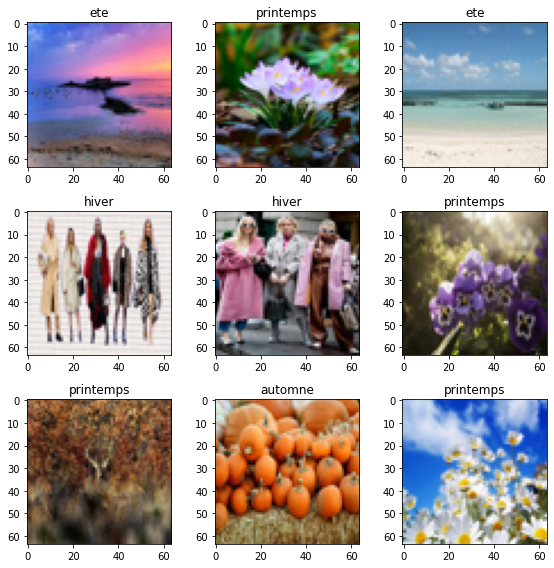

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
shuffle_indices = np.random.permutation(y_train.shape[0])
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = x_train[shuffle_indices[i]]
    plt.title(labels[int(y_train[shuffle_indices[i]])])
    plt.imshow(image/255)

plt.tight_layout()
plt.show()

Normalisation des entrées via une division par 255 des valeurs de pixel.


In [8]:
x_train = x_train / 255
x_test = x_test / 255
x_val = x_val / 255

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')




## Réseau convolutif de base et entrainement des données 

In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn import datasets

from tensorflow.keras.layers import Conv2D, MaxPooling2D , Dense, Flatten, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers , Input , losses

In [10]:
def create_model():
  
  model = Sequential()
  #model.add(Input(shape=(64, 64, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(64, kernel_size= (3,3), activation = 'relu'))
  model.add(MaxPooling2D(2,2))

  model.add(Conv2D(96, kernel_size= (3,3), activation = 'relu'))
  model.add(MaxPooling2D(2,2))

  model.add(Conv2D(128, kernel_size= (3,3),  activation = 'relu'))
  model.add(MaxPooling2D(2,2))

  model.add(Flatten())

  model.add(Dense(512, activation='relu'))
  model.add(Dense(4, activation='softmax'))

  model.build()


  model.summary()

  return model 

In [11]:
model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 96)         0

In [12]:
# compile model
opt = optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy' , metrics = ['accuracy'])

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20)

Epoch 1/20
147/147 [==============================] - 15s 11ms/step - loss: 1.1720 - accuracy: 0.4818 - val_loss: 1.0002 - val_accuracy: 0.5772
Epoch 2/20
147/147 [==============================] - 1s 8ms/step - loss: 0.8790 - accuracy: 0.6470 - val_loss: 0.7722 - val_accuracy: 0.7064
Epoch 3/20
147/147 [==============================] - 1s 9ms/step - loss: 0.7440 - accuracy: 0.7155 - val_loss: 0.6787 - val_accuracy: 0.7365
Epoch 4/20
147/147 [==============================] - 1s 9ms/step - loss: 0.6898 - accuracy: 0.7442 - val_loss: 0.6084 - val_accuracy: 0.7675
Epoch 5/20
147/147 [==============================] - 2s 11ms/step - loss: 0.6399 - accuracy: 0.7631 - val_loss: 0.6631 - val_accuracy: 0.7255
Epoch 6/20
147/147 [==============================] - 1s 8ms/step - loss: 0.5952 - accuracy: 0.7801 - val_loss: 0.5408 - val_accuracy: 0.8026
Epoch 7/20
147/147 [==============================] - 1s 9ms/step - loss: 0.5547 - accuracy: 0.7935 - val_loss: 0.4797 - val_accuracy: 0.8312
Epo

# Affichage de l'ananlyse de l'entrainement

In [13]:
def plot_training_analysis(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

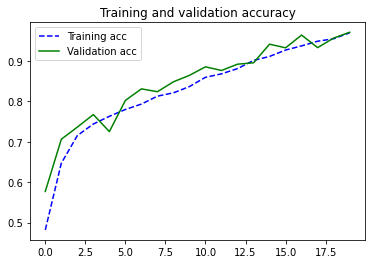

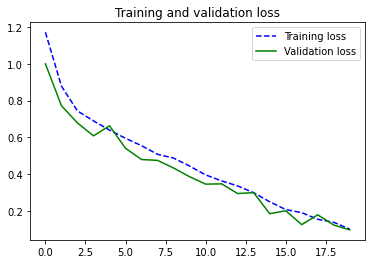

In [14]:

plot_training_analysis(history)


Evaluation pour les données de test :

In [15]:
model.evaluate(x_test,y_test)

58/58 [==============================] - 0s 4ms/step - loss: 0.1058 - accuracy: 0.9651


[0.10580934584140778, 0.9651415944099426]

In [16]:
#enregistrer le modèle 2
model.save('weather_model.h5')

## Augmentation de la base de données : 

On utilise deux types d'augmentation : des transformations spatiales (ShiftScaleRotate), et des transformations colorimétriques. 

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )


Visualisation des images passées à travers notre boucle d'augmentation de données.

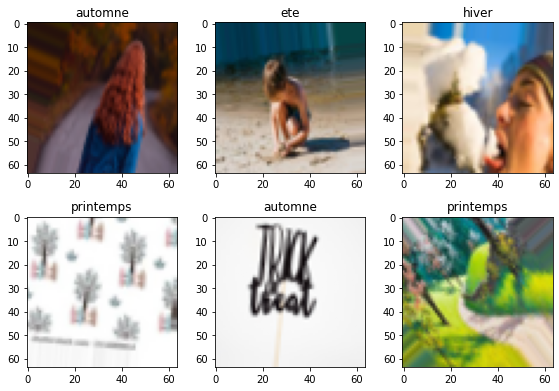

In [18]:
# prepare iterator
it = datagen.flow(x_train, y_train, batch_size=6)

plt.figure(figsize=(8, 8))
for i in range(0, 6):
    plt.subplot(3, 3, i+1)
    xs, ys = it.next()
    image = xs[0]
    plt.title(labels[int(ys[0])])
    plt.imshow(image)

plt.tight_layout()
plt.show()

Nous allons recréer un autre modèle et relancer l'entraînement.

In [19]:
model = create_model()
opt = optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy' , metrics = ['accuracy'])



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 96)        55392     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 96)        

In [20]:
a, b = datagen.flow(x_train, y_train, batch_size=x_train.shape[0]).next()
history = model.fit(a, b, validation_data=(x_val, y_val), epochs=30)


Epoch 1/30
147/147 [==============================] - 2s 10ms/step - loss: 1.2072 - accuracy: 0.4561 - val_loss: 1.0586 - val_accuracy: 0.5135
Epoch 2/30
147/147 [==============================] - 1s 8ms/step - loss: 0.9698 - accuracy: 0.6007 - val_loss: 0.9832 - val_accuracy: 0.5832
Epoch 3/30
147/147 [==============================] - 1s 9ms/step - loss: 0.8046 - accuracy: 0.6940 - val_loss: 0.7350 - val_accuracy: 0.7295
Epoch 4/30
147/147 [==============================] - 1s 8ms/step - loss: 0.7518 - accuracy: 0.7138 - val_loss: 0.7261 - val_accuracy: 0.7255
Epoch 5/30
147/147 [==============================] - 1s 8ms/step - loss: 0.7159 - accuracy: 0.7323 - val_loss: 0.7033 - val_accuracy: 0.7360
Epoch 6/30
147/147 [==============================] - 1s 8ms/step - loss: 0.6636 - accuracy: 0.7497 - val_loss: 0.7078 - val_accuracy: 0.7199
Epoch 7/30
147/147 [==============================] - 1s 8ms/step - loss: 0.6401 - accuracy: 0.7544 - val_loss: 0.6257 - val_accuracy: 0.7670
Epoch

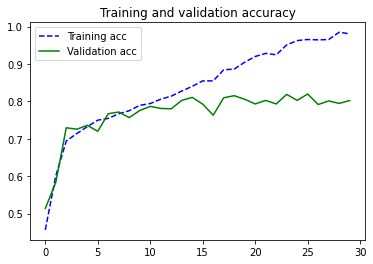

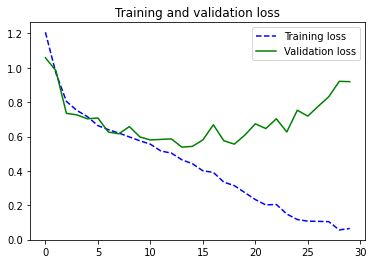

In [21]:
plot_training_analysis(history)

In [22]:
#enregistrer le modèle 2
model.save('weather_model2.h5')

# Transfer Learning

In [23]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
                  include_top=False, # On ne conserve pas la partie Dense du réseau originel
                  input_shape=(64, 64, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [24]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [25]:
train_features = conv_base.predict(x_train)
train_features = np.reshape(train_features,(train_features.shape[0],2*2*512))

val_features = conv_base.predict(x_val)
val_features = np.reshape(val_features,(val_features.shape[0],2*2*512))

In [26]:
model = Sequential()

model.add(Input(shape=(2*2*512)))
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.summary()


model.compile(optimizer=optimizers.Adam(lr=3e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])


history = model.fit(train_features, y_train,
                    epochs=10,
                    batch_size=16,
                    validation_data=(val_features, y_val))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 525,572
Trainable params: 525,572
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


294/294 [==============================] - 1s 4ms/step - loss: 0.7994 - accuracy: 0.6781 - val_loss: 0.5594 - val_accuracy: 0.7936
Epoch 2/5
294/294 [==============================] - 1s 3ms/step - loss: 0.5607 - accuracy: 0.7961 - val_loss: 0.4518 - val_accuracy: 0.8392
Epoch 3/5
294/294 [==============================] - 1s 4ms/step - loss: 0.4756 - accuracy: 0.8256 - val_loss: 0.4353 - val_accuracy: 0.8317
Epoch 4/5
294/294 [==============================] - 1s 3ms/step - loss: 0.4176 - accuracy: 0.8452 - val_loss: 0.3487 - val_accuracy: 0.8747
Epoch 5/5
294/294 [==============================] - 1s 4ms/step - loss: 0.3676 - accuracy: 0.8733 - val_loss: 0.2972 - val_accuracy: 0.9028


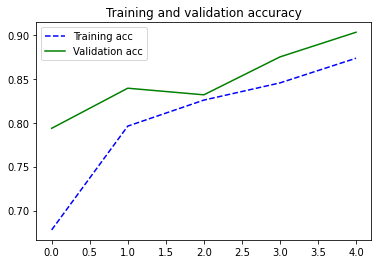

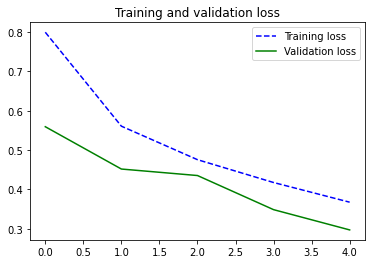

In [27]:
plot_training_analysis(history)

On a du surapprentissage acc = 99.5% donc on cherche a **intégrer** de l'augmentation de données texte en gras

In [28]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))
conv_base.trainable = False
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 15,240,260
Trainable params: 525,572
Non-trainable params: 14,714,688
_________________________________________________________________


In [29]:
opt = optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy' , metrics = ['accuracy'])



In [30]:
a, b = datagen.flow(x_train, y_train, batch_size=x_train.shape[0]).next()
history = model.fit(a, b, validation_data=(x_val, y_val), epochs=30)


Epoch 1/30
147/147 [==============================] - 4s 27ms/step - loss: 0.9018 - accuracy: 0.6364 - val_loss: 0.7267 - val_accuracy: 0.7044
Epoch 2/30
147/147 [==============================] - 4s 26ms/step - loss: 0.6759 - accuracy: 0.7404 - val_loss: 0.6116 - val_accuracy: 0.7620
Epoch 3/30
147/147 [==============================] - 4s 25ms/step - loss: 0.5822 - accuracy: 0.7759 - val_loss: 0.5991 - val_accuracy: 0.7730
Epoch 4/30
147/147 [==============================] - 4s 25ms/step - loss: 0.5195 - accuracy: 0.8061 - val_loss: 0.6496 - val_accuracy: 0.7490
Epoch 5/30
147/147 [==============================] - 4s 25ms/step - loss: 0.4734 - accuracy: 0.8352 - val_loss: 0.6003 - val_accuracy: 0.7595
Epoch 6/30
147/147 [==============================] - 4s 25ms/step - loss: 0.4224 - accuracy: 0.8492 - val_loss: 0.5644 - val_accuracy: 0.7801
Epoch 7/30
147/147 [==============================] - 4s 25ms/step - loss: 0.3751 - accuracy: 0.8720 - val_loss: 0.5778 - val_accuracy: 0.7806

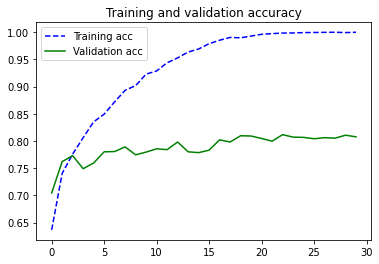

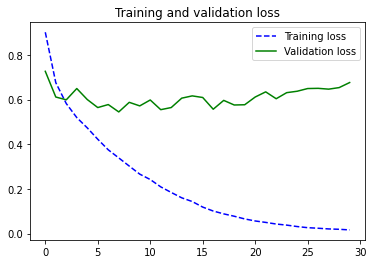

In [31]:
plot_training_analysis(history)

## Tester pour des entrées non présentes dans les données d'entrainement:

In [32]:
def load_image(path):
  img = Image.open(path)
 
  img = img.resize((64, 64))
  return np.asarray(img)

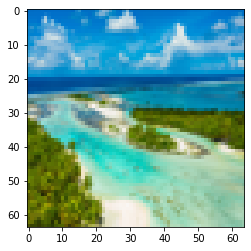

In [33]:
from keras.models import load_model
img = load_image('img_classification/test.jpg')
plt.imshow(img)


In [35]:
prediction_img = [img]

result = model.predict(np.array(prediction_img))


array([[0., 0., 1., 0.]], dtype=float32)

In [45]:
def get_y_pred(tab):
  i = 0
  while tab[i] == 0:
    i += 1
  
  return CLASSES[i]



In [46]:
print("the image belongs to the class :",  get_y_pred(result[0]))

the image belongs to the class : ete
